In [54]:
from alpha_vantage.timeseries import TimeSeries
import polars as pl
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

In [11]:
api_key = 'OZAI9AV07M9II90V'
ts = TimeSeries(key=api_key, output_format='pandas')

data, meta_data = ts.get_intraday(symbol='TSLA', interval='1min', outputsize='full')

In [15]:
meta_data

{'1. Information': 'Intraday (1min) open, high, low, close prices and volume',
 '2. Symbol': 'TSLA',
 '3. Last Refreshed': '2024-05-10 19:59:00',
 '4. Interval': '1min',
 '5. Output Size': 'Full size',
 '6. Time Zone': 'US/Eastern'}

#### Preprocess

In [118]:
polars_df = pl.from_pandas(data.reset_index())
polars_df = polars_df.rename({col: col[3:] for col in polars_df.columns if col != "date"}).sort("date")
polars_df = polars_df.filter(pl.col('date').apply(lambda x: x.weekday() < 5))

/var/folders/7w/k34p2t0s65174v8d11sqy5c80000gn/T/ipykernel_17489/2262431016.py:3: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  polars_df = polars_df.filter(pl.col('date').apply(lambda x: x.weekday() < 5))
/var/folders/7w/k34p2t0s65174v8d11sqy5c80000gn/T/ipykernel_17489/2262431016.py:3: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  polars_df = polars_df.filter(pl.col('date').apply(lambda x: x.weekday() < 5))


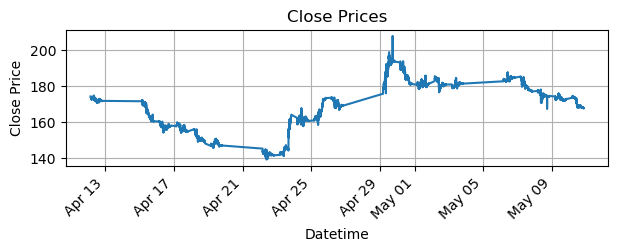

In [119]:
pandas_df_for_plotting = polars_df.to_pandas()

plt.figure(figsize=(7, 2))
plt.plot(pandas_df_for_plotting['date'], pandas_df_for_plotting['close'])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gcf().autofmt_xdate()
plt.title('Close Prices')
plt.xlabel('Datetime')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### Color Volume Bars

In [122]:
polars_df = polars_df.with_columns([
    polars_df['close'].shift(10).alias('price_2_weeks_ago'),
    polars_df['volume'].shift(10).alias('volume_2_weeks_ago')
])

polars_df = polars_df.with_columns([
    pl.when((pl.col('close') > pl.col('price_2_weeks_ago')) & (pl.col('volume') > pl.col('volume_2_weeks_ago')))
    .then(pl.lit('green'))
    .when((pl.col('close') > pl.col('price_2_weeks_ago')) & (pl.col('volume') <= pl.col('volume_2_weeks_ago')))
    .then(pl.lit('blue'))
    .when((pl.col('close') < pl.col('price_2_weeks_ago')) & (pl.col('volume') > pl.col('volume_2_weeks_ago')))
    .then(pl.lit('red'))
    .when((pl.col('close') < pl.col('price_2_weeks_ago')) & (pl.col('volume') <= pl.col('volume_2_weeks_ago')))
    .then(pl.lit('orange'))
    .otherwise(pl.lit('black'))
    .alias('color')
])

#### Plotting

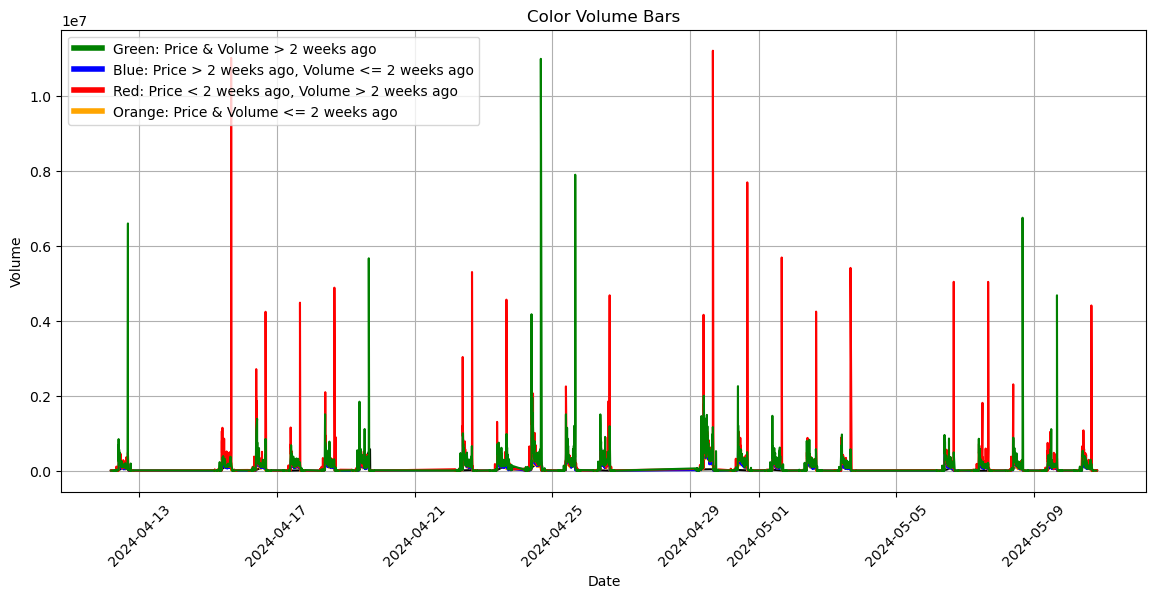

In [138]:
pandas_df = polars_df.to_pandas()

plt.figure(figsize=(14, 6))
for color in pandas_df['color'].unique():
    color_df = pandas_df[pandas_df['color'] == color]
    plt.plot(color_df['date'], color_df['volume'], color=color, label=color)

plt.title('Color Volume Bars')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.grid(True)

legend_elements = [
    Line2D([0], [0], color='green', lw=4, label='Green: Price & Volume > 2 weeks ago'),
    Line2D([0], [0], color='blue', lw=4, label='Blue: Price > 2 weeks ago, Volume <= 2 weeks ago'),
    Line2D([0], [0], color='red', lw=4, label='Red: Price < 2 weeks ago, Volume > 2 weeks ago'),
    Line2D([0], [0], color='orange', lw=4, label='Orange: Price & Volume <= 2 weeks ago')
]

plt.legend(handles=legend_elements, loc='upper left')

plt.show()